In [3]:
# Import Required Packages
import pandas as pd
import os
import re
from google.colab import drive
import matplotlib.pyplot as plt
from glob import glob
from IPython.display import Audio, display
import time

In [4]:
# Create functions to retrive date and time from CSV file names
def get_date(l):
  date = None
  for e in l:
    if "2021" in e:
      date = e
    elif "2022" in e:
      date = e
  return date

def get_time(l):
  time = None
  for e in l:
    if re.match("^([0-1]?[0-9]|2[0-3]):[0-5][0-9]$", e):
      time = e
  return time

In [5]:
# Mount Google Drive for Data Access
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Create list of all CSV files in model folder
PATH = "/content/drive/MyDrive/Segmentation Data/aerial/models/Ferris"
EXT = "*.csv"
all_csv_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, EXT))]

In [7]:
# Store highest dice score and corresponding epoch of each document
highest_dice = {}
for file in all_csv_files:
  try:
    df = pd.read_csv(file)
    df = df[df["epoch"] != 'epoch']
    df["epoch"] = range(len(df))
    df['dice'] = df['dice'].apply(lambda x: float(x))
    highest_dice[file] = [df.loc[df['dice'].idxmax()].epoch, df.dice.max()]
  except:
    print("Exception: file Error")
    print(file)

# Create new final comparison DataFrame
df = pd.DataFrame(highest_dice.items())
df.columns = ["Path", "Dice"]
df[['Epoch','Dice']] = pd.DataFrame(df.Dice.tolist(), index= df.index)

# Reorganize DataFrame
df.Path = df.Path.str.strip("/content/drive/MyDrive/Segmentation Data/aerial/models/Ferris")
df.loc[df['Path'].str.contains("hrnet"), 'architecture'] = 'HRNET'
df.loc[df['Path'].str.contains("U-Net"), 'architecture'] = 'U-Net'
df.loc[df['Path'].str.contains("256x256"), 'image size'] = '256'
df.loc[~(df['Path'].str.contains("256x256")), 'image size'] = '512'
df.loc[df['Path'].str.contains("FOC"), 'fit function'] = 'fit_one_cycle'
df.loc[df['Path'].str.contains("FT|fine_tune"), 'fit function'] = 'fine_tune'
df.loc[df['Path'].str.contains("resnet34"), 'backbone'] = 'Resnet34'
df.loc[df['Path'].str.contains("resnet18"), 'backbone'] = 'Resnet18'
df.loc[df['Path'].str.contains("resnet50"), 'backbone'] = 'Resnet50'
df.loc[df['Path'].str.contains("resnet152"), 'backbone'] = 'Resnet152'
df.loc[df['Path'].str.contains("w48"), 'backbone'] = 'W48' # . ”W32” and ”W48” represent the channel dimensions of the highresolution subnetworks in last three stages of HRNet
df.loc[df['Path'].str.contains("w32"), 'backbone'] = 'W32' 
df.loc[df['Path'].str.contains("w30"), 'backbone'] = 'W30' 
df.loc[df['Path'].str.contains("w18"), 'backbone'] = 'W18' 
df.loc[df['Path'].str.contains("squeezenet1"), 'backbone'] = 'SqueezeNet 1' 
df.loc[df['Path'].str.contains("vgg16"), 'backbone'] = 'VGG16'
df.loc[df['Path'].str.contains("alexnet"), 'backbone'] = 'AlexNet' 
df.loc[df['Path'].str.contains("lr: default"), 'learning rate'] = 'Default' 
df.loc[df['Path'].str.contains("Default Loss|Default loss"), 'loss function'] = 'Default' 
df.loc[df['Path'].str.contains("CombinedLoss"), 'loss function'] = 'Combined Loss' 
df.loc[df['Path'].str.contains("Dual_Focal_loss"), 'loss function'] = 'Dual Focal Loss' 
df.loc[df['Path'].str.contains("FocalLoss"), 'loss function'] = 'Focal Loss'
df["Path_split"] = df['Path'].str.strip(".")
df["Path_split"] = df['Path_split'].str.split("_")
df["Date"] = df['Path_split'].apply(get_date)
df["Time"] = df['Path_split'].apply(get_time)

In [ ]:
# Save DataFrame as CSV for later easy retrieval
df.to_csv("/content/drive/MyDrive/Segmentation Data/aerial/models/2022.01.25_Model Comparison.csv")

In [3]:
# Read DataFrame from stored CSV file for further analysis
df = pd.read_csv("/content/drive/MyDrive/Segmentation Data/aerial/models/Model Comparison.csv")
df

,Unnamed: 0,Path,Dice,Epoch,architecture,image size,fit function,backbone,learning rate,loss function,Path_split,Date,Time
0,0,U-Net_resnet34_Default Loss_FOC_2022-01-03_11:07.,0.927302,44,U-Net,512,fit_one_cycle,Resnet34,NaN,Default,"['U-Net', 'resnet34', 'Default Loss', 'FOC', '...",2022-01-03,11:07
1,1,U-Net_resnet34_Default Loss_FOC_2022-01-03_13:37.,0.884714,13,U-Net,512,fit_one_cycle,Resnet34,NaN,Default,"['U-Net', 'resnet34', 'Default Loss', 'FOC', '...",2022-01-03,13:37
2,2,U-Net_resnet34_Default Loss_FOC_2022-01-03_15:23.,0.894218,3,U-Net,512,fit_one_cycle,Resnet34,NaN,Default,"['U-Net', 'resnet34', 'Default Loss', 'FOC', '...",2022-01-03,15:23
3,3,U-Net_resnet152_Default Loss_FOC_2022-01-03_16...,0.929184,45,U-Net,512,fit_one_cycle,Resnet152,NaN,Default,"['U-Net', 'resnet152', 'Default Loss', 'FOC', ...",2022-01-03,16:29
4,4,U-Net_resnet152_Dual_Focal_loss_FOC_2022-01-04...,0.933089,36,U-Net,512,fit_one_cycle,Resnet152,NaN,Dual Focal Loss,"['U-Net', 'resnet152', 'Dual', 'Focal', 'loss'...",2022-01-04,09:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,U-Net_2021-12-20_18:45_FT_resnet18_FocalLoss.,0.918945,59,U-Net,512,fine_tune,Resnet18,NaN,Focal Loss,"['U-Net', '2021-12-20', '18:45', 'FT', 'resnet...",2021-12-20,18:45
97,97,U-Net_2021-12-26_17:46_FOC 200_ valid: 0.4_lr:...,0.932035,75,U-Net,512,fit_one_cycle,NaN,Default,NaN,"['U-Net', '2021-12-26', '17:46', 'FOC 200', ' ...",2021-12-26,17:46
98,98,U-Net_2021-12-23_17:45_FT 1-120_2.,0.820402,15,U-Net,512,fine_tune,NaN,NaN,NaN,"['U-Net', '2021-12-23', '17:45', 'FT 1-120', '2']",2021-12-23,17:45
99,99,U-Net_2021-12-22_12:28_resnet18_FocalLoss_fine...,0.882615,0,U-Net,512,fine_tune,Resnet18,NaN,Focal Loss,"['U-Net', '2021-12-22', '12:28', 'resnet18', '...",2021-12-22,12:28


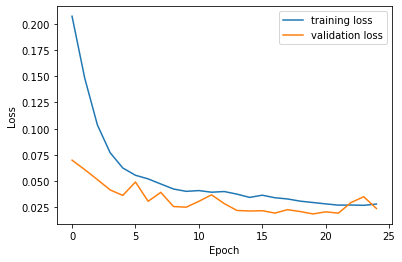

In [11]:
# Plot loss curves of specific model
df_plot = pd.read_csv("/content/drive/MyDrive/Segmentation Data/aerial/models/Ferris/U-Net_2021-12-24_04:07_FOC 200, valid: 0.1, lr: default.csv")
df_plot = df_plot.iloc[:25]
df_plot = df_plot.apply(pd.to_numeric, errors = 'coerce')

lines = df_plot.plot.line(x = 'epoch', y = ['train_loss', 'valid_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.show()

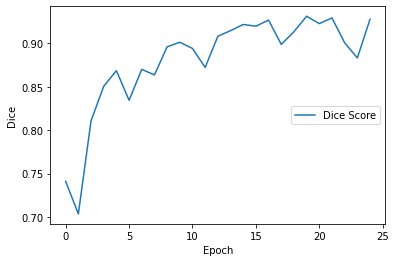

In [12]:
# Plot corresponding Dice score
lines = df_plot.plot.line(x = 'epoch', y = ['dice'])

plt.ylabel('Dice')
plt.xlabel('Epoch')
plt.legend(['Dice Score', 'validation loss'], loc = 'center right')
plt.show()